In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

set_matplotlib_formats("svg", "pdf")

C:\Users\Corrado Mio\AppData\Local\Temp\ipykernel_8616\2202065716.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")


In [3]:
print("Using torch", torch.__version__)

Using torch 1.13.1+cu116


In [4]:
torch.manual_seed(42)  # Setting the seed

In [5]:
x = Tensor(2, 3, 4)
print(x)

tensor([[[4.4082e-39, 4.5918e-39, 4.4082e-39, 8.4489e-39],
         [1.0102e-38, 1.0561e-38, 1.0653e-38, 1.0469e-38],
         [9.5510e-39, 9.9184e-39, 9.0000e-39, 1.0561e-38]],

        [[1.0653e-38, 4.1327e-39, 8.9082e-39, 9.8265e-39],
         [9.4592e-39, 1.0561e-38, 9.6429e-39, 1.1112e-38],
         [9.2755e-39, 1.0102e-38, 9.9184e-39, 9.8265e-39]]])


In [6]:
x = torch.ones((3,))
print(x.requires_grad)

False


In [7]:
x.requires_grad_(True)
print(x.requires_grad)

True


In [8]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)  # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [9]:
a = x + 2
b = a**2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


In [10]:
y.backward()

In [11]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

In [15]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [17]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In [18]:
x

tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')

In [21]:
x = torch.randn(5000, 5000)

# CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

# GPU version
if torch.cuda.is_available():
    x = x.to(device)
    # CUDA is asynchronous, so we need to use different timing functions
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    _ = torch.matmul(x, x)
    end.record()
    torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
    print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 0.78523s
GPU time: 0.23270s


In [22]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [23]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [24]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
model

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [26]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [27]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9927, 0.9875]), tensor(0))


In [32]:
def visualize_samples(data, label):
    if isinstance(data, Tensor):
        data = data.cpu().numpy()
    if isinstance(label, Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0", marker='.')
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1", marker='.')
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

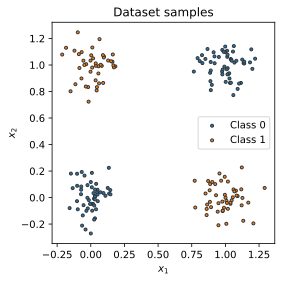

In [33]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [35]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [36]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs torch.Size([8, 2]) 
 tensor([[-0.0162,  0.7235],
        [-0.0147, -0.0188],
        [ 0.1260,  0.0727],
        [-0.0718,  0.0593],
        [ 0.8294,  1.0141],
        [ 0.9245,  0.1017],
        [ 1.0673,  1.0178],
        [ 0.7934,  1.0516]])
Data labels torch.Size([8]) 
 tensor([1, 0, 0, 0, 0, 1, 0, 0])


In [37]:
loss_module = nn.BCEWithLogitsLoss()

In [38]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [39]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [40]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [41]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 5: Update the parameters
            optimizer.step()

In [42]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.8940, -0.2608],
        [-0.7049, -0.3176],
        [ 2.1021,  2.5932],
        [ 2.0286, -2.4488]], device='cuda:0')), ('linear1.bias', tensor([ 1.2214,  0.6289, -0.8958, -1.2350], device='cuda:0')), ('linear2.weight', tensor([[2.3551, 0.6243, 3.0601, 2.8041]], device='cuda:0')), ('linear2.bias', tensor([-0.2303], device='cuda:0'))])


In [44]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [45]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.8940, -0.2608],
        [-0.7049, -0.3176],
        [ 2.1021,  2.5932],
        [ 2.0286, -2.4488]], device='cuda:0')), ('linear1.bias', tensor([ 1.2214,  0.6289, -0.8958, -1.2350], device='cuda:0')), ('linear2.weight', tensor([[2.3551, 0.6243, 3.0601, 2.8041]], device='cuda:0')), ('linear2.bias', tensor([-0.2303], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.8940, -0.2608],
        [-0.7049, -0.3176],
        [ 2.1021,  2.5932],
        [ 2.0286, -2.4488]])), ('linear1.bias', tensor([ 1.2214,  0.6289, -0.8958, -1.2350])), ('linear2.weight', tensor([[2.3551, 0.6243, 3.0601, 2.8041]])), ('linear2.bias', tensor([-0.2303]))])


In [46]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [47]:
def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [48]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


D:\Python\Anaconda3-2022.05\envs\torch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


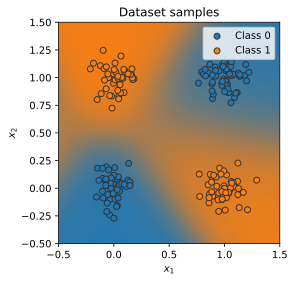

In [49]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, Tensor):
        data = data.cpu().numpy()
    if isinstance(label, Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = Tensor(to_rgba("C0")).to(device)
    c1 = Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    # Specifying "None" in a dimension creates a new one
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = (
        output_image.cpu().numpy()
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)


visualize_classification(model, dataset.data, dataset.label)
plt.show()